**Team 2010617 / Mar 9, 2020**

# Common imports

In [1]:
# basic imports
import operator
from time import time
from dateutil import parser
from collections import defaultdict
import numpy as np
np.random.seed(42)
import pandas as pd
original_data_path = './Data/original-provided'
processing_data_path = './Data/data-processing'
word_clouds_path = './Results/word_clouds'
from cv2 import imread
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings('ignore')

In [2]:
# basic sklearn
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, roc_curve, auc

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import MinMaxScaler, Normalizer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, KFold
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline

In [3]:
# models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

from mlxtend.regressor import StackingRegressor
from sklearn.multioutput import MultiOutputRegressor

In [4]:
# some NLP packages
import nltk
#nltk.download('stopwords')
#nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from wordcloud import WordCloud
# clusters
from sklearn.cluster import SpectralCoclustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics.cluster import v_measure_score

# Preprocessing

In [5]:
df_dy = pd.read_csv(f'{original_data_path}/hair_dryer.tsv', sep ='\t') # 11470
df_wv = pd.read_csv(f'{original_data_path}/microwave.tsv', sep ='\t') # 1615
df_pc = pd.read_csv(f'{original_data_path}/pacifier.tsv', sep ='\t') # 18939

df = df_dy.append([df_wv, df_pc], ignore_index=True) # shape: (32024, 15)

## Drop meaningless columns

- marketplace: either 'US' or 'us',

In [6]:
df.marketplace.value_counts()

US    24276
us     7748
Name: marketplace, dtype: int64

- review_id: all unique

In [7]:
pd.unique(df_dy.review_id).shape[0] == df_dy.shape[0]

True

- Drop these two factors

In [8]:
#df.drop(['marketplace', 'review_id'], axis=1, inplace=True)
df.drop(['marketplace'], axis=1, inplace=True)

## Four missing values

In [9]:
np.sum(df.isna(), axis=0)

customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      2
review_body          2
review_date          0
dtype: int64

### Fill missing review_body with its review_headline

In [10]:
df.iloc[np.array(df.review_body.isna()), :]

,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
14035,38484571,R74VTHE48J4IQ,B0028IDXDS,450475749,wubbanub brown monkey pacifier,Baby,3,3,3,N,Y,Smaller,NaN,7/17/2015
16541,45456400,R3BVF5UJ5TMXHK,B003CK3LDI,392768822,wubbanub infant pacifier - giraffe,Baby,5,2,2,N,Y,Five Stars,NaN,3/30/2015


In [11]:
df.loc[np.array(df.review_body.isna()), 'review_body'] = df.loc[np.array(df.review_body.isna()), 'review_headline']

### Fill missing review_headline with its stars

In [12]:
df.loc[np.array(df.review_headline.isna()), :]

,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
273,51177255,R2TW4FSXQ60M75,B001UE7D2I,127343313,andis 1875-watt tourmaline ceramic ionic styli...,Beauty,5,0,0,N,Y,NaN,Used once - recently cut hair - Sure to use it...,8/9/2015
2433,11212444,R24Y12M6JKTTQM,B00MEBKQ8E,646149518,"panasonic hair dryer nano care, vivid pink, 1 ...",Beauty,4,0,1,N,Y,NaN,It is very nice ! Motor sounds are not cheep d...,2/17/2015


In [13]:
df.loc[273, 'review_headline'] = 'five stars'
df.loc[2433, 'review_headline'] = 'four stars'

## Duplicates values

- We found 4 and 12 duplicate values in each of the two datasets, microwave ovens and baby pacifiers.

- While it’s reasonable for parents to buy a pacifier product several times at the same date and write same reviews, it seems that the duplicated reviews of microwave oven, written by a person for 4 times at a single day, are just repeated complaints about his awful experience.

- Also given that all the duplicated pacifier reviews were purchase-verified which were not for ovens’, we keep all the pacifier reviews but only one for those 4 duplicated microwave oven reviews.

In [14]:
new = df[['customer_id', 'product_parent', 'product_title', 'product_category',
          'star_rating', 'review_headline', 'review_body', 'review_date', 'vine', 'verified_purchase']]
dup = new.iloc[np.array(new.duplicated(keep =0)), :].copy()
dup.sort_values(by = ['customer_id', 'product_category', 'product_title'], inplace=True)
dup

,customer_id,product_parent,product_title,product_category,star_rating,review_headline,review_body,review_date,vine,verified_purchase
18023,1792224,68041075,baby dipper feeding set - new larger 6-ounce n...,baby,5,five stars,very happy. i have both blue and pink,2/4/2015,n,y
18065,1792224,68041075,baby dipper feeding set - new larger 6-ounce n...,baby,5,five stars,very happy. i have both blue and pink,2/4/2015,n,y
21356,2946686,381226741,philips avent bpa free contemporary freeflow p...,Baby,4,"the baby sucking only love, time is not","Yes, the baby sucking only love, time is not long",9/17/2014,N,Y
21376,2946686,381226741,philips avent bpa free contemporary freeflow p...,Baby,4,"the baby sucking only love, time is not","Yes, the baby sucking only love, time is not long",9/17/2014,N,Y
22321,10159677,381226741,philips avent bpa free contemporary freeflow p...,Baby,5,Five Stars,good,8/8/2014,N,Y
22331,10159677,381226741,philips avent bpa free contemporary freeflow p...,Baby,5,Five Stars,good,8/8/2014,N,Y
15320,11470803,955350284,dr. brown's prevent classic pacifier,Baby,5,Five Stars,excellent product,5/18/2015,N,Y
15330,11470803,955350284,dr. brown's prevent classic pacifier,Baby,5,Five Stars,excellent product,5/18/2015,N,Y
15319,11470803,667171015,fctry - baby pacifiers,Baby,5,Five Stars,excellent product,5/18/2015,N,Y
15345,11470803,667171015,fctry - baby pacifiers,Baby,5,Five Stars,excellent product,5/18/2015,N,Y


In [15]:
df.drop([12864, 12865, 12866],axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

## Strings' capitalization

In [16]:
df.vine = df.vine.str.upper()
df.verified_purchase = df.verified_purchase.str.lower()
df.product_category = df.product_category.str.lower()

In [17]:
df.vine.value_counts()

N    31690
Y      331
Name: vine, dtype: int64

In [18]:
df.verified_purchase.value_counts()

y    27167
n     4854
Name: verified_purchase, dtype: int64

In [19]:
df.product_category.value_counts()

baby                18939
beauty              11470
major appliances     1612
Name: product_category, dtype: int64

## Datetime format

- Also can be set by pandas.read_csv

In [20]:
date = []
for i in df.index:
    date.append(parser.parse(df.loc[i, 'review_date']))
df.review_date = date

# Exploratory data analysis

## Generate more numeric features

### helpful ratio & unhelpful ratio

- Assuming everyone voted in a fair manner on whether others’ reviews are helpful, so the voting results are objective and accurate.
- Assuming that the reviews written by Customers who were authorized as Amazon Vine Voices are accurate and can be over-weighted.

We combine some ratio-like features. For example, we divide the ’total_votes’ by ’helpful_votes’ to get ’helpful_ratio’.

In [21]:
zero_index = df.query('total_votes == 0').index
other_index = list(set(df.index) - set(zero_index))

df.loc[zero_index, 'helpful_ratio'] = 0
df.loc[zero_index, 'unhelpful_ratio'] = 0
for i in other_index:
    df.loc[i, 'helpful_ratio'] = df.loc[i, 'helpful_votes'] / df.loc[i, 'total_votes']
    df.loc[i, 'unhelpful_ratio'] = 1 - df.loc[i, 'helpful_ratio']

### Measure the importance of helpful ratio

After which Entropy-weight method and TOPSIS method will be introduced

In [22]:
print(df.query('helpful_ratio != 0 & product_category == "beauty"').shape)
print(df.query('helpful_ratio == 0 & product_category == "beauty"').shape)

(3699, 16)
(7771, 16)


## Urgent need to sentiment features

What we need more from texts ?

- Positive, Negtive, Neutral
- Understandable, Complexity
- One-sided, Two-sided
- Official, Unofficial
- Helpness

In [23]:
from textblob import TextBlob
data = list(df.review_body)
blob = TextBlob(data[0])
print(blob)
blob.sentiment

Works great!


Sentiment(polarity=1.0, subjectivity=0.75)

In [24]:
blob = TextBlob(data[1])
print(blob)
blob.sentiment

This dries my hair faster that bigger, more powerful models. I love travel blow dryers because they are easy to lift and they usually come in 1600 w or less. Bigger dryers are heavy and blow my hair everywhere. This has a surprising amount of power and is very compact. I would give it a five except that the switch is not easy to turn on and off with one hand and it's noisier than I anticipated.


Sentiment(polarity=0.15, subjectivity=0.5319444444444444)

In [25]:
# for index in data.length
sentiment = []
for index in range(len(data)):
    blob = TextBlob(data[index])
    sentiment.append((blob.sentiment.polarity+1)*2.5);

In [26]:
sentiment_df = pd.DataFrame({'sentiment_list': sentiment})
display(sentiment_df)

,sentiment_list
0,5.000000
1,2.875000
2,4.062500
3,2.500000
4,4.000000
...,...
32016,3.129650
32017,3.282986
32018,3.666667
32019,2.384348


In [130]:
review_df = review_df.join(sentiment_df)

ValueError: columns overlap but no suffix specified: Index(['sentiment_list'], dtype='object')

In [131]:
display(review_df)

,product_category,star_rating,review_headline,review_body,review_date,review_length,sentiment_list
0,beauty,5,Works great,Works great!,2015-08-31,12,5.000000
1,beauty,4,I love travel blow dryers because they are eas...,"This dries my hair faster that bigger, more po...",2015-08-31,397,2.875000
2,beauty,5,Five Stars,Love this dryer!,2015-08-31,16,4.062500
3,beauty,5,Five Stars,styling hair in style,2015-08-31,21,2.500000
4,beauty,4,I think's great. The cord length is perfect,I just got this last week. I think's great. Th...,2015-08-31,71,4.000000
...,...,...,...,...,...,...,...
32016,baby,2,Not for bottle liners,We have been using the bottle warmer and have ...,2004-05-24,408,3.129650
32017,baby,4,good enough for me,"This isn't the greatest product ever invented,...",2004-04-04,256,3.282986
32018,baby,5,I love it!,I love this bottle warmer. After researching ...,2004-04-04,282,3.666667
32019,baby,1,save your money,I finally broke down and opened this shower gi...,2003-12-02,511,2.384348


In [138]:
year = []
for i in df.index:
    year.append(df.loc[i, 'review_date'].year)
year_df = pd.DataFrame({'year': year})
review_df = review_df.join(year_df)

ValueError: columns overlap but no suffix specified: Index(['year'], dtype='object')

In [27]:
review_length = []
for index in range(len(data)):
    review_length.append(len(data[index]))
    
review_length_df = pd.DataFrame({'review_length': review_length})
display(review_length_df)

,review_length
0,12
1,397
2,16
3,21
4,71
...,...
32016,408
32017,256
32018,282
32019,511


In [28]:
new_1 = df[['product_category' ,'star_rating', 'review_headline', 'review_body', 'review_date']]
review_df  = new_1.join(review_length_df)
display(review_df)

,product_category,star_rating,review_headline,review_body,review_date,review_length
0,beauty,5,Works great,Works great!,2015-08-31,12
1,beauty,4,I love travel blow dryers because they are eas...,"This dries my hair faster that bigger, more po...",2015-08-31,397
2,beauty,5,Five Stars,Love this dryer!,2015-08-31,16
3,beauty,5,Five Stars,styling hair in style,2015-08-31,21
4,beauty,4,I think's great. The cord length is perfect,I just got this last week. I think's great. Th...,2015-08-31,71
...,...,...,...,...,...,...
32016,baby,2,Not for bottle liners,We have been using the bottle warmer and have ...,2004-05-24,408
32017,baby,4,good enough for me,"This isn't the greatest product ever invented,...",2004-04-04,256
32018,baby,5,I love it!,I love this bottle warmer. After researching ...,2004-04-04,282
32019,baby,1,save your money,I finally broke down and opened this shower gi...,2003-12-02,511


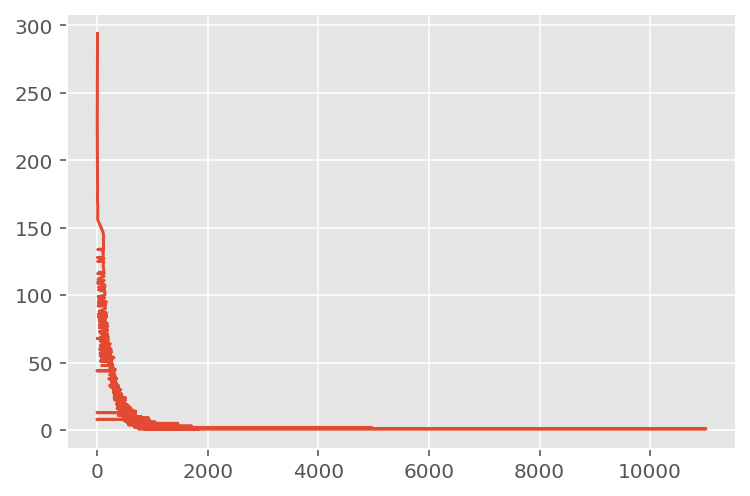

In [29]:
values = review_df.review_length.value_counts().keys().tolist()
counts = review_df.review_length.value_counts().tolist()

plt.plot(values, counts)

In [30]:
print(review_df.query('star_rating == 1').shape)
print(review_df.query('star_rating == 2').shape)
print(review_df.query('star_rating == 3').shape)
print(review_df.query('star_rating == 4').shape)
print(review_df.query('star_rating == 5').shape)

(2623, 6)
(1696, 6)
(2559, 6)
(5112, 6)
(20031, 6)


In [31]:
from astropy.table import Table
data_rows = [(1, 2623),
             (2, 1696),
             (3, 2559),
             (4, 5112),
             (5, 20031)]
star_review_table = Table(rows=data_rows, names=('star_rating', 'review_number'))
print(star_review_table)

star_rating review_number
----------- -------------
          1          2623
          2          1696
          3          2559
          4          5112
          5         20031


In [32]:
review_df.product_category.value_counts()

baby                18939
beauty              11470
major appliances     1612
Name: product_category, dtype: int64

In [33]:
from astropy.table import Table
data_rows = [('baby', 18939),
             ('beauty', 11470),
             ('major appliances', 1612)]
product_review_table = Table(rows=data_rows, names=('product_category', 'review_number'))
print(product_review_table)

product_category review_number
---------------- -------------
            baby         18939
          beauty         11470
major appliances          1612


In [34]:
df_dy.product_category.value_counts()

Beauty    11470
Name: product_category, dtype: int64

In [35]:
df.star_rating.value_counts()

5    20031
4     5112
1     2623
3     2559
2     1696
Name: star_rating, dtype: int64

In [36]:
review_df.review_length

0         12
1        397
2         16
3         21
4         71
        ... 
32016    408
32017    256
32018    282
32019    511
32020    479
Name: review_length, Length: 32021, dtype: int64

In [37]:
np.corrcoef(review_df.star_rating, review_df.review_length)

array([[ 1.        , -0.13145581],
       [-0.13145581,  1.        ]])

In [38]:
np.corrcoef(review_df.star_rating, sentiment_df.sentiment_list)

array([[1.        , 0.41368745],
       [0.41368745, 1.        ]])

In [39]:
np.corrcoef(review_df.star_rating, df.helpful_ratio)

array([[ 1.        , -0.17063038],
       [-0.17063038,  1.        ]])

In [40]:
print(len(df_wv.product_parent.value_counts()))
df_wv.product_parent.value_counts()

55


423421857    394
544821753     80
109226352     79
771401205     78
827502283     76
523301568     74
295520151     74
943347999     49
305608994     45
692404913     44
459626087     41
486381187     33
930071734     32
690479711     30
464779766     28
565072108     28
242727854     27
494668275     26
392967251     25
618770050     24
542519500     23
921964554     21
984005611     19
731025324     19
991090482     16
784164614     15
522487135     15
981162112     15
801135043     14
215953885     14
168181302     14
721617315     13
166483932     13
809249591     13
838179571     12
760984384     12
572011672     12
994339247     12
379992322     11
155528792     11
309267414     11
147401377     10
862802057      1
788261054      1
149559260      1
313983847      1
550562680      1
664466484      1
311592014      1
454581724      1
494028413      1
539049610      1
542731946      1
632928046      1
665261008      1
Name: product_parent, dtype: int64

In [49]:
parent_df = df[['product_parent' ,'star_rating', 'review_headline', 'review_body', 'review_date']]
parent_df['review_date'] =pd.to_datetime(parent_df.review_date)
parent_df.sort_values(by=['review_date'], ascending=False, inplace=True)
parent_df

,product_parent,star_rating,review_headline,review_body,review_date
0,732252283,5,Works great,Works great!,2015-08-31
1,670161917,4,I love travel blow dryers because they are eas...,"This dries my hair faster that bigger, more po...",2015-08-31
13096,295960359,5,Five Stars,Very Cute,2015-08-31
13095,339747365,5,Baby's favorite,These are the only type of pacifier that my ba...,2015-08-31
13094,181638405,4,Four Stars,He likes them over all the others and that's w...,2015-08-31
...,...,...,...,...,...
11465,919751065,5,great hair!,"I just purchased this dryer, and I really like...",2002-08-21
11466,694290590,1,Disappointment with dryer,I purchased it because it was supposed to be q...,2002-08-13
11467,694290590,5,The best dryer!!!,"I love this dryer not only is it QUIET, it rea...",2002-07-13
11468,694290590,5,Excellent for fine/limp hair,This hairdryer far exceeded my expection for<B...,2002-04-20


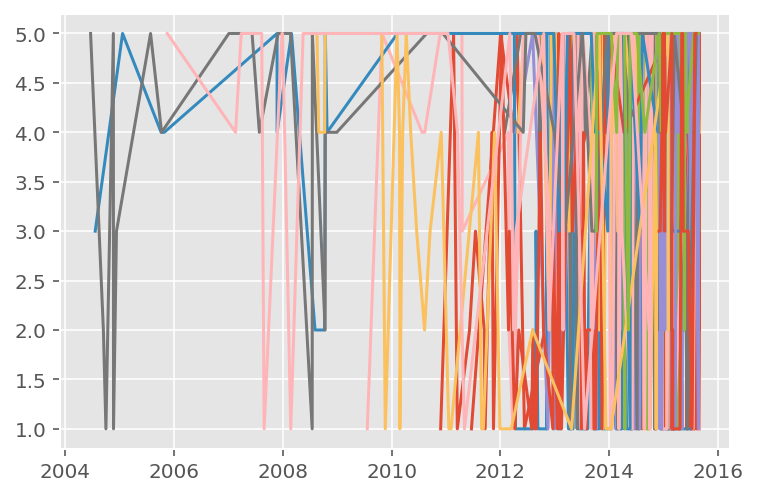

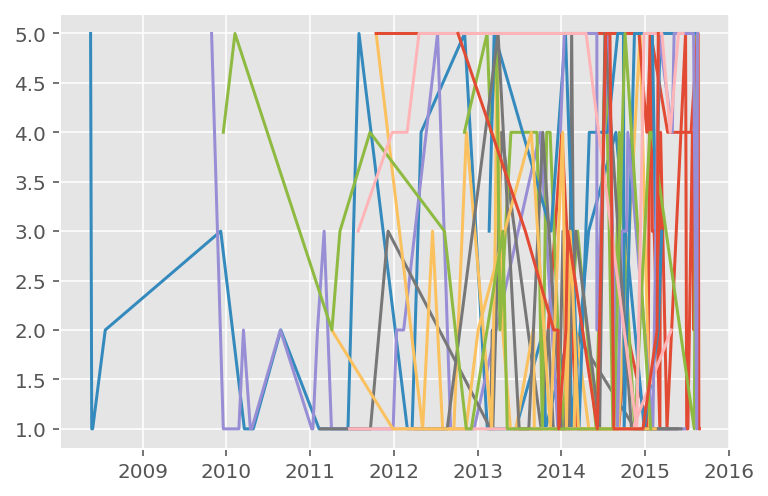

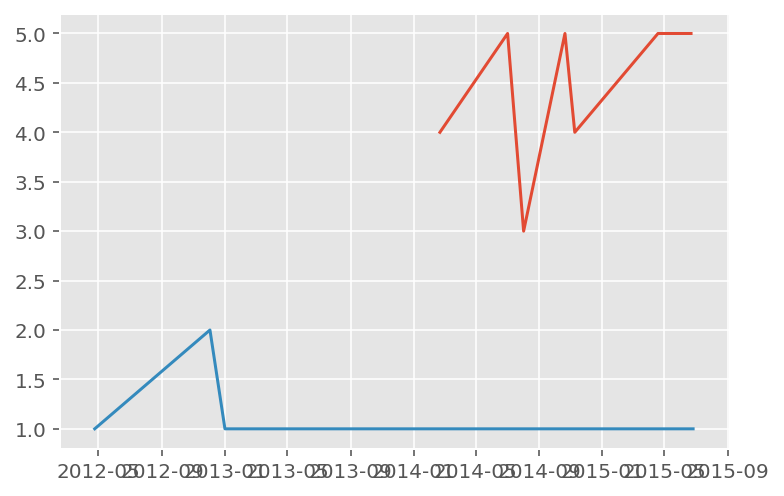

In [42]:
# x = parent_df.query('product_parent == 423421857').review_date # x_coordinate
# y = parent_df.query('product_parent == 423421857').star_rating # y_coordinate
# plt.plot(x, y)
# x1 = parent_df.query('product_parent == 544821753').review_date # x_coordinate
# y1 = parent_df.query('product_parent == 544821753').star_rating # y_coordinate
# plt.plot(x1, y1)
# plt.show()
head_list = df_wv.product_parent.value_counts().head(15).index.tolist()
for i in range(len(head_list)):
    x = parent_df[parent_df.product_parent == head_list[i]].review_date # x_coordinate  
    y = parent_df[parent_df.product_parent == head_list[i]].star_rating # y_coordinate
    plt.plot(x, y)
plt.show()

middle_list = df_wv.product_parent.value_counts().tail(40).head(15).index.tolist()
for i in range(len(middle_list)):
    x = parent_df[parent_df.product_parent == middle_list[i]].review_date # x_coordinate  
    y = parent_df[parent_df.product_parent == middle_list[i]].star_rating # y_coordinate
    plt.plot(x, y)
plt.show()

tail_list = df_wv.product_parent.value_counts().tail(15).index.tolist()
for i in range(len(tail_list)):
    x = parent_df[parent_df.product_parent == tail_list[i]].review_date # x_coordinate  
    y = parent_df[parent_df.product_parent == tail_list[i]].star_rating # y_coordinate
    plt.plot(x, y)
plt.show()

In [139]:
# review_number_1 = []
# # review_df.query("star_rating == 1 & review_date == 2002").shape[0]
# review_number_1.append(review_df.query("star_rating == 1 & review_date == 2002").shape[0])
# review_number_1.append(review_df.query("star_rating == 1 & review_date == 2003").shape[0])
# print(review_number_1)
review_number = []
for star in range(1, 6):
    inner = []
    for year in range(2002, 2016):
        inner.append(review_df.query("star_rating == @star & year == @year").shape[0]) 
    review_number.append(inner)    
print(review_number)

sentiment_number = []
for senti in range(1, 6):
    inner = []
    for year in range(2002, 2016):
        inner.append(review_df.query("sentiment_list <= @senti & sentiment_list > @senti-1 & year == @year").shape[0]) 
    sentiment_number.append(inner)    
print(sentiment_number)

[[1, 1, 5, 16, 21, 37, 59, 47, 114, 192, 262, 445, 722, 701], [0, 1, 4, 8, 13, 19, 32, 40, 70, 127, 148, 338, 480, 416], [1, 2, 4, 10, 8, 17, 35, 40, 64, 157, 196, 516, 758, 751], [1, 2, 3, 17, 20, 73, 91, 100, 168, 313, 430, 1068, 1513, 1313], [5, 6, 6, 67, 34, 150, 241, 260, 496, 917, 1453, 3789, 6300, 6307]]
[[0, 0, 0, 0, 2, 0, 0, 1, 1, 5, 3, 9, 28, 23], [0, 0, 0, 0, 1, 7, 12, 9, 15, 28, 41, 135, 244, 261], [7, 11, 16, 66, 58, 132, 220, 245, 475, 845, 1172, 2617, 3887, 3542], [1, 0, 6, 50, 33, 147, 213, 213, 384, 763, 1171, 3040, 4167, 3835], [0, 1, 0, 2, 2, 10, 13, 19, 37, 65, 102, 351, 1444, 1815]]


In [24]:
data = list(df.review_body)
Analyzer = SentimentIntensityAnalyzer()
sentiment = {'neg': [], 'neu': [], 'pos': [], 'compound': []}
for sentence in data:
    score_dict = Analyzer.polarity_scores(sentence)
    for key, value in score_dict.items():
        sentiment[key].append(np.abs(value))

In [25]:
arg = []
senti = pd.DataFrame(sentiment)
senti.columns = ['neg','neu','pos','understandable']
map_dict = {0: 'one', 1: 'two', 2: 'one'}
for i in senti.index:
    arg.append(np.argmax(senti.iloc[i,:3]))
    senti.loc[i, 'sides'] = map_dict[arg[-1]]

senti['complexity'] = np.exp(-senti.understandable)

sides = pd.DataFrame(OneHotEncoder().fit_transform(np.array(senti['sides']).reshape(-1,1)).toarray())
sides.columns = ['one_side', 'two_sides']

argframe = pd.DataFrame(arg)
argframe.columns = ['attitude_target']

atti = pd.DataFrame(OneHotEncoder().fit_transform(np.array(arg).reshape(-1,1)).toarray())
atti.columns = ['att_neg', 'att_neu', 'att_pos']

vine = pd.DataFrame(OneHotEncoder().fit_transform(np.array(df['vine']).reshape(-1,1)).toarray())
vine.columns = ['vine_N', 'vine_Y']

veri = pd.DataFrame(OneHotEncoder().fit_transform(np.array(df['verified_purchase']).reshape(-1,1)).toarray())
veri.columns = ['veri_n', 'veri_y']

senti.drop('sides', axis=1, inplace=True)

df = pd.concat([df, senti, argframe, sides, atti, vine, veri], axis=1)

In [26]:
helpness = pd.read_csv(f'{processing_data_path}/helpfulness.csv')

helpness = helpness.loc[:, ['plt','entropyRank.score']].copy()
helpness.columns = ['review_id', 'helpness']

df = df.merge(helpness, on='review_id', how='outer')
helpnow = SimpleImputer(strategy='median').fit_transform(np.array(df.helpness).reshape(-1, 1))

helpnow = MinMaxScaler().fit_transform(helpnow)
df.helpness = helpnow

In [27]:
df.shape

(32021, 32)

In [28]:
df.iloc[:, 12:]

,review_body,review_date,helpful_ratio,unhelpful_ratio,neg,neu,pos,understandable,complexity,attitude_target,one_side,two_sides,att_neg,att_neu,att_pos,vine_N,vine_Y,veri_n,veri_y,helpness
0,Works great!,2015-08-31,0.0,0.0,0.000,0.185,0.815,0.6588,0.517472,2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.041772
1,"This dries my hair faster that bigger, more po...",2015-08-31,0.0,0.0,0.000,0.777,0.223,0.9562,0.384351,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.054008
2,Love this dryer!,2015-08-31,0.0,1.0,0.000,0.308,0.692,0.6696,0.511913,2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.042235
3,styling hair in style,2015-08-31,0.0,0.0,0.000,1.000,0.000,0.0000,1.000000,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.010019
4,I just got this last week. I think's great. Th...,2015-08-31,0.0,0.0,0.000,0.562,0.438,0.8316,0.435352,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.038982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32016,We have been using the bottle warmer and have ...,2004-05-24,0.0,0.0,0.000,0.807,0.193,0.9186,0.399077,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.042495
32017,"This isn't the greatest product ever invented,...",2004-04-04,1.0,0.0,0.095,0.781,0.124,0.3645,0.694544,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.335531
32018,I love this bottle warmer. After researching ...,2004-04-04,0.0,0.0,0.000,0.576,0.424,0.9829,0.374224,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.045043
32019,I finally broke down and opened this shower gi...,2003-12-02,1.0,0.0,0.063,0.754,0.183,0.9200,0.398519,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.360334


In [29]:
df.to_csv(f'{processing_data_path}/df.csv', index=False)

# Gain insights from several observations

Several papers discuss about adjusting star rating in a weighted method according to the degree of deviation from mean and standard deviation.

## Observe the differences between the three products

product_category
baby                AxesSubplot(0.125,0.125;0.775x0.755)
beauty              AxesSubplot(0.125,0.125;0.775x0.755)
major appliances    AxesSubplot(0.125,0.125;0.775x0.755)
Name: star_rating, dtype: object

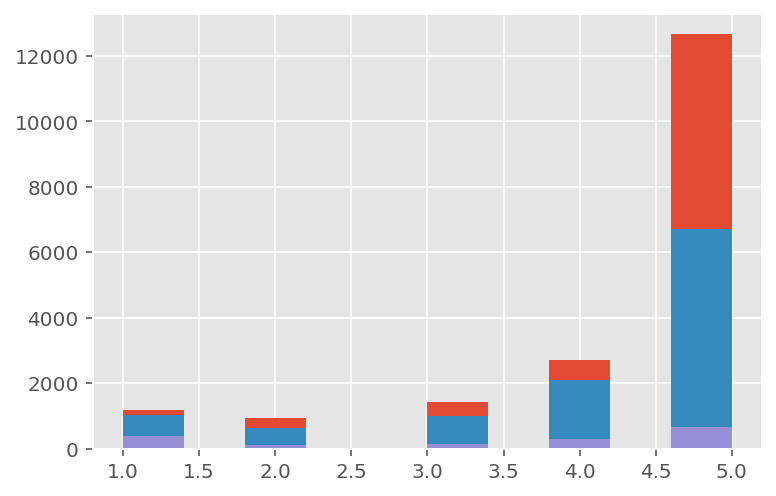

In [30]:
df.groupby(by=['product_category'])['star_rating'].hist()

## Observe the differences between experts' and non-experts' scores

In [31]:
df.groupby(by=['product_category'])['star_rating'].mean()

product_category
baby                4.304557
beauty              4.116042
major appliances    3.449132
Name: star_rating, dtype: float64

In [32]:
df.groupby(by=['product_category'])['star_rating'].std()


product_category
baby                1.190426
beauty              1.300333
major appliances    1.643381
Name: star_rating, dtype: float64

In [33]:
df.groupby(by=['vine', 'product_category'])['star_rating'].count()

vine  product_category
N     baby                18806
      beauty              11291
      major appliances     1593
Y     baby                  133
      beauty                179
      major appliances       19
Name: star_rating, dtype: int64

In [34]:
df.groupby(by=['vine', 'product_category'])['star_rating'].mean()

vine  product_category
N     baby                4.304371
      beauty              4.110885
      major appliances    3.438167
Y     baby                4.330827
      beauty              4.441341
      major appliances    4.368421
Name: star_rating, dtype: float64

In [35]:
df.groupby(by=['vine', 'product_category'])['star_rating'].std()

vine  product_category
N     baby                1.192277
      beauty              1.306493
      major appliances    1.648465
Y     baby                0.893765
      beauty              0.757487
      major appliances    0.683986
Name: star_rating, dtype: float64

## Observe the length of reviews

common value：9


Text(0.5, 1.0, "Reviews' length of hair dryer")

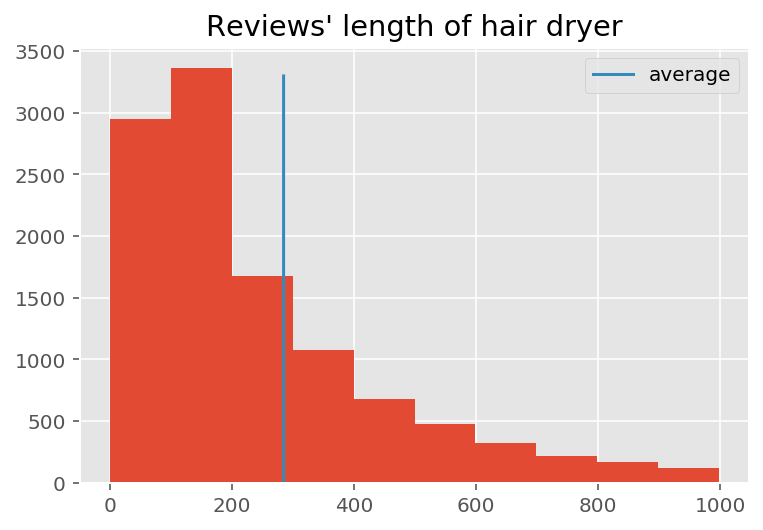

In [36]:
df1 = df.query('product_category == "beauty"')

length = []
for i in df1.index:
    lenn = len(df1.loc[i, 'review_body'])
    length.append(lenn)
length_less = np.array(length)[np.array(length) < 1000]
print(f'common value：{np.argmax(np.bincount(length))}')
pd.DataFrame(length_less).hist()
plt.plot([np.mean(length)]*3300, range(3300),label = 'average')
plt.legend()
plt.title("Reviews' length of hair dryer")

common value：9


Text(0.5, 1.0, "Reviews' length of baby pacifier")

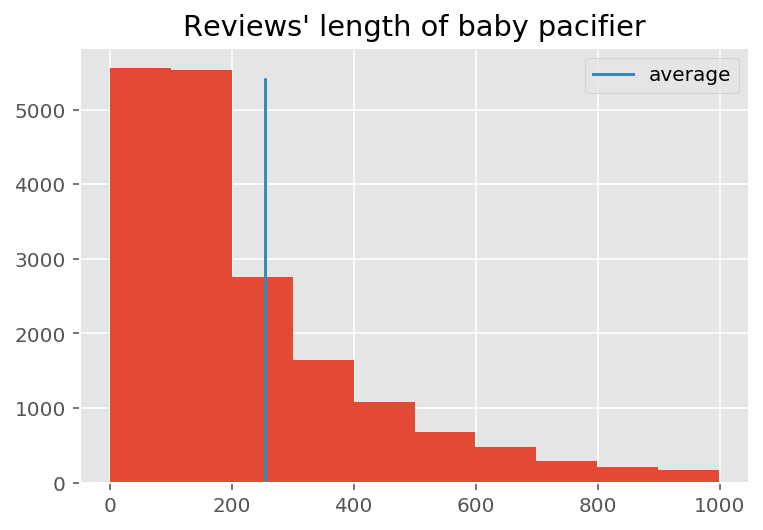

In [37]:
df1 = df.query('product_category == "baby"')

length = []
for i in df1.index:
    lenn = len(df1.loc[i, 'review_body'])
    length.append(lenn)
length_less = np.array(length)[np.array(length) < 1000]
print(f'common value：{np.argmax(np.bincount(length))}')
pd.DataFrame(length_less).hist()
plt.plot([np.mean(length)]*5400, range(5400),label = 'average')
plt.legend()
plt.title("Reviews' length of baby pacifier")

common value：12


Text(0.5, 1.0, "Reviews' length of microwave ovens")

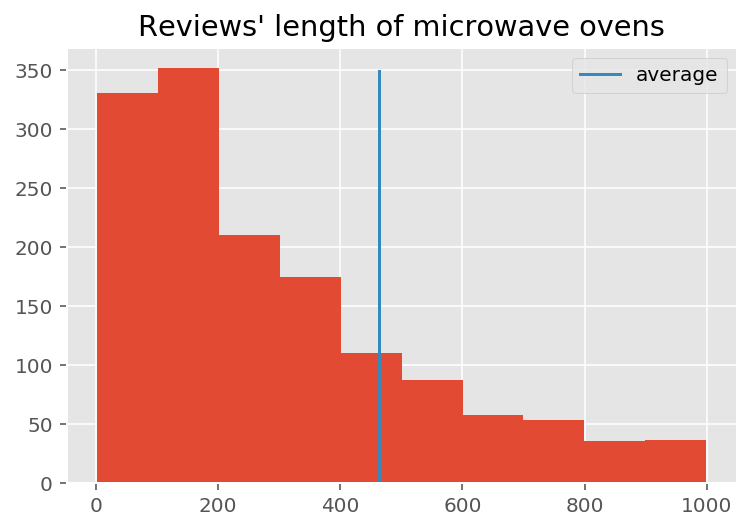

In [38]:
df1 = df.query('product_category == "major appliances"')

length = []
for i in df1.index:
    lenn = len(df1.loc[i, 'review_body'])
    length.append(lenn)
length_less = np.array(length)[np.array(length) < 1000]
print(f'common value：{np.argmax(np.bincount(length))}')
pd.DataFrame(length_less).hist()
plt.plot([np.mean(length)]*350, range(350),label = 'average')
plt.legend()
plt.title("Reviews' length of microwave ovens")

# Further processing

In [39]:
df = pd.read_csv(f'{processing_data_path}/df.csv')
df.shape

(32021, 32)

## Seperate by categories

In [40]:
pc = df.query('product_category == "baby"')
dy = df.query('product_category == "beauty"')
wv = df.query('product_category == "major appliances"')
pc.sort_values(by=['product_parent'], inplace=True)  # 5432 rows
dy.sort_values(by=['product_parent'], inplace=True)  # 473 rows
wv.sort_values(by=['product_parent'], inplace=True)  # 55 rows

## Group by product parent

In [41]:
def GroupAnalysis(frame):
    frame_sales = pd.DataFrame(frame.product_parent.value_counts())
    frame_sales.columns = ['sales']

    frame_mean = frame.groupby(by='product_parent')[['star_rating','neg','pos','neu','helpness']].mean()
    frame_mean = pd.DataFrame(frame_mean)
    frame_mean.index = [i for i in frame_mean.index]

    frame_sum = frame.groupby(by='product_parent')[['vine_Y','veri_y','two_sides']].sum()
                                            #'att_neg','att_neu','att_pos']].sum()
    frame_sum = pd.DataFrame(frame_sum)
    frame_sum.index = [i for i in frame_sum.index]

    frame_reg = pd.concat([frame_sales, frame_mean, frame_sum], axis=1)

    num = np.array(list(frame_reg.vine_Y + frame_reg.veri_y))
    txt = np.array(list(frame_reg.two_sides + frame_reg.helpness))
    rate = np.array(list(frame_reg.star_rating))
    if num.shape[0] > 1:
        num = (MinMaxScaler().fit_transform(num.reshape(-1, 1))).flatten()
        txt = (MinMaxScaler().fit_transform(txt.reshape(-1, 1))).flatten()
        num += np.random.randn(num.shape[0]) * 0.03
        exp_num = MinMaxScaler().fit_transform((rate*np.exp(num)).flatten().reshape(-1, 1))
        exp_txt = MinMaxScaler().fit_transform((rate*np.exp(txt)).flatten().reshape(-1, 1))
        rate_exp_num = pd.DataFrame(5*exp_num, index=frame_reg.index, columns=['rate_exp_num'])
        rate_exp_txt = pd.DataFrame(5*exp_txt, index=frame_reg.index, columns=['rate_exp_txt'])
    else:
        exp_num = rate * np.exp(num)
        exp_txt = rate * np.exp(txt)
        rate_exp_num = pd.DataFrame(min(exp_num,5), index=frame_reg.index, columns=['rate_exp_num'])
        rate_exp_txt = pd.DataFrame(min(exp_txt,5), index=frame_reg.index, columns=['rate_exp_txt'])
    
    new_frame = pd.concat([frame_reg, rate_exp_num, rate_exp_txt], axis=1)
    new_frame.index.name = 'index'
    return new_frame

In [42]:
pc_reg = GroupAnalysis(pc)
dy_reg = GroupAnalysis(dy)
wv_reg = GroupAnalysis(wv)

In [43]:
pc_reg.to_csv(f'{processing_data_path}/pc_reg.csv')
dy_reg.to_csv(f'{processing_data_path}/dy_reg.csv')
wv_reg.to_csv(f'{processing_data_path}/wv_reg.csv')

## Visualizations of origin star rating mechanism

- Among various extraction ways we have, star_rating is the most basic and intuitive feature to show a consumer’s feeling, which is also the first layer of Amazon’s mechanism.
- We can generate a scatter plot between the sales and mean_star_rating of each hair dryer, aggregated by product_parent.
- However, the plot turn out to be meaningless as all the points gathered together around a high star_rating while sales are very different.
- Therefore, review-based measures are essential and needed to be added

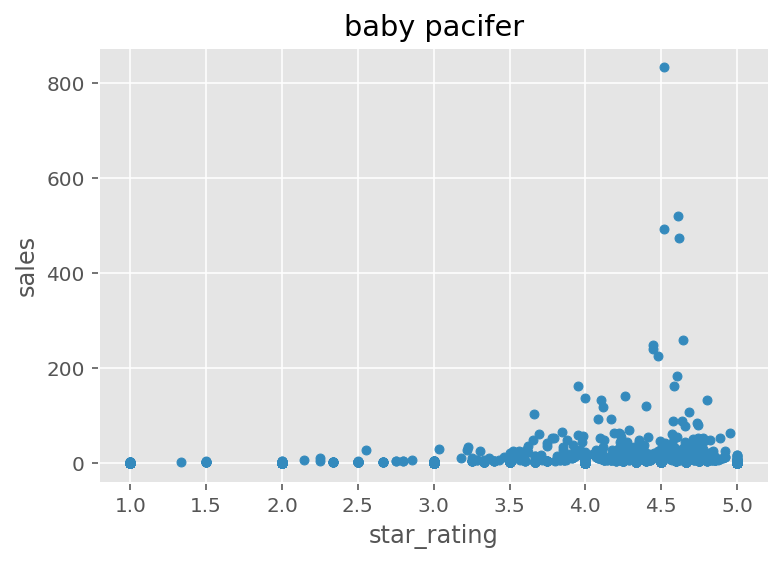

In [44]:
pc_reg.plot(x='star_rating', y='sales', kind='scatter', title='baby pacifer')

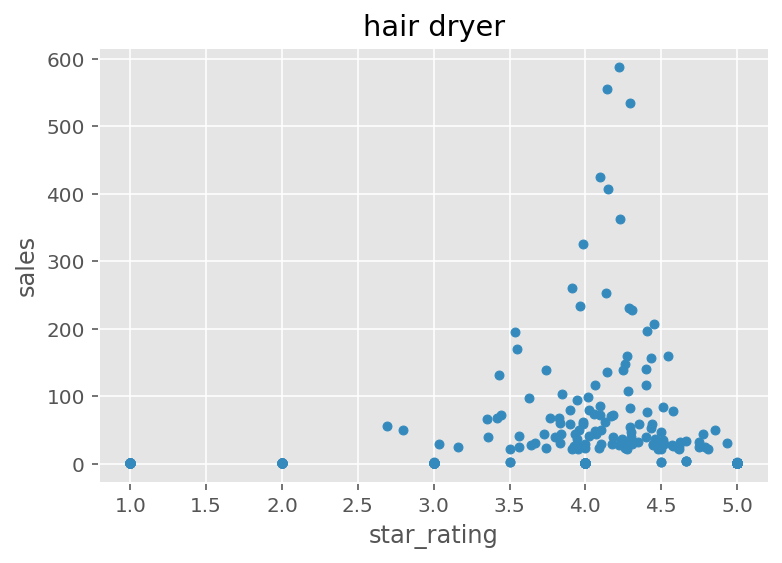

In [45]:
dy_reg.plot(x='star_rating', y='sales', kind='scatter', title='hair dryer')

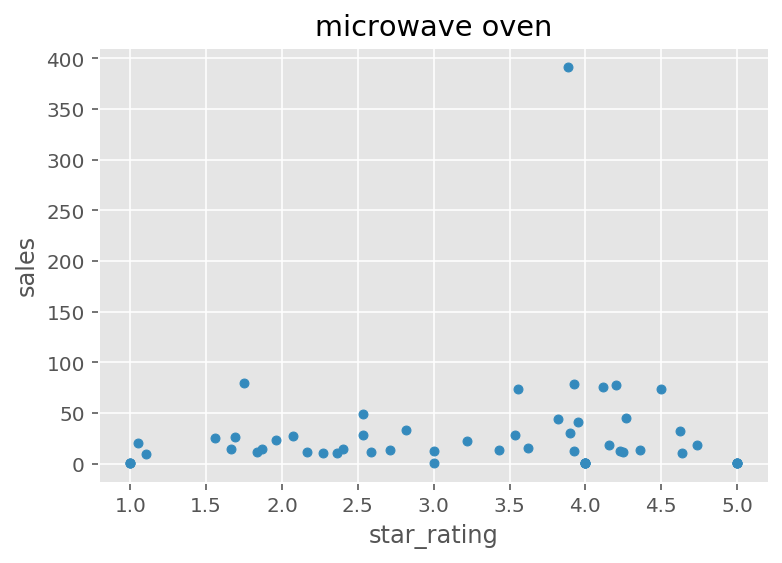

In [46]:
wv_reg.plot(x='star_rating', y='sales', kind='scatter', title='microwave oven')

# Most Informative Measures to Track

- Sales & two weighted rating variables

## Linear Regression

In [47]:
pc_reg = pd.read_csv(f'{processing_data_path}/pc_reg.csv', index_col='index')
dy_reg = pd.read_csv(f'{processing_data_path}/dy_reg.csv', index_col='index')
wv_reg = pd.read_csv(f'{processing_data_path}/wv_reg.csv', index_col='index')

In [48]:
reg_models = {
    'linear': LinearRegression(),
    #'ridge': Ridge(), 
    #'lasso': Lasso(),
    #'logistic': LogisticRegression(),
    #'elastic': ElasticNet(),
    #'sgd': SGDRegressor(), 
    #'bayes': BayesianRidge(),
    #'RF': RandomForestRegressor(),
    #'GB': GradientBoostingRegressor(),
    #'ET': ExtraTreesRegressor(),
    #'AB': AdaBoostRegressor(),
    #'SVR': SVR(),
    #'LinerSVR': LinearSVR(),
    #'DT': DecisionTreeRegressor(),
    #'KernelRidge': KernelRidge(),
    #'XGB': XGBRegressor(),
    #'Stacking': StackingRegressor()
}

In [49]:
def DataTransformer(frame, features='reputation'):
    col = ['sales','star_rating','rate_exp_num','rate_exp_txt'] if features == 'reputation' else features
    data = frame.loc[:, col].copy()
    label = data[col[0]].copy()
    train = data.drop(col[0], axis=1)
    encoder = MinMaxScaler()
    train_scaled = encoder.fit_transform(train)
    return train_scaled, train.columns, label

In [50]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [51]:
def model_cv(X, y, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=False)
    model_cv_results = pd.DataFrame()
    
    for name, model in reg_models.items():
        score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kfold, n_jobs=1)
        print(f"{name:>20s}{score.mean():14.6f}{score.std():10.4f}") # check cv schedule during training
        model_cv_results = model_cv_results.append(pd.DataFrame([(name, score.mean(), score.std())]))

    model_cv_results.columns = ['name', 'mean', 'std']
    model_cv_results.sort_values(by=['mean'], ascending=False, inplace=True)
    model_cv_results.reset_index(drop=True, inplace=True)
    print("------------------------------"*2)
    return model_cv_results

In [52]:
def Regression(frame=wv_reg, features='reputation', n_splits=5, words=None):
    print(words)
    # Data transforming
    train_scaled, train_columns, label = DataTransformer(frame, features=features)
    
    # Linear Regression
    model_cv_results = model_cv(train_scaled, label, n_splits=n_splits)
    
    # coef & intercept of Linear Regression
    model1 = LinearRegression().fit(train_scaled, label)
    feature_important = model1.coef_
    attribs = train_columns
    print(f'intercept = {model1.intercept_}')
    print(sorted(zip(feature_important, attribs), reverse=True))
    print("------------------------------"*2)
    
    # Feature importance of RandomForest
    model2 = RandomForestRegressor(random_state=4).fit(train_scaled, label)
    feature_important = model2.feature_importances_
    attribs = train_columns
    print(f'Feature importance:\n{sorted(zip(feature_important, attribs), reverse=True)}')
    print("========================================================="*2)

In [53]:
Regression(frame = wv_reg, words='microwave oven')
Regression(frame = dy_reg, words='hair dryer')
Regression(frame = pc_reg, words='baby pacifier')

microwave oven
              linear   -219.444444  331.0208
------------------------------------------------------------
intercept = 13.3120133766331
[(828.3402576297593, 'rate_exp_txt'), (-254.59268556761933, 'star_rating'), (-258.8356202109579, 'rate_exp_num')]
------------------------------------------------------------
Feature importance:
[(0.47960375902734736, 'rate_exp_txt'), (0.402800329531911, 'rate_exp_num'), (0.11759591144074161, 'star_rating')]
hair dryer
              linear   -239.227423  150.0860
------------------------------------------------------------
intercept = 5.040186110086793
[(945.0438987858911, 'rate_exp_txt'), (51.7376292320606, 'rate_exp_num'), (-380.9052551178753, 'star_rating')]
------------------------------------------------------------
Feature importance:
[(0.7782913877138876, 'rate_exp_txt'), (0.1499111012653097, 'rate_exp_num'), (0.07179751102080262, 'star_rating')]
baby pacifier
              linear    -18.568779   21.1010
---------------------------

## Analysis & diagnosis with R

In [54]:
%%R
df <- read.table('./Data/data-processing/wv_reg.csv', header = T, sep=',')

ggplot(data = df) + 
  geom_point(mapping = aes(x = star_rating, y = sales)) + 
  geom_smooth(mapping = aes(x = star_rating, y = sales), se = F)
ggsave(filename = "./Results/Regression-results/wv_star_rating.png",width = 12,height = 9)

ggplot(data = df) + 
  geom_point(mapping = aes(x = rate_exp_num, y = sales)) + 
  geom_smooth(mapping = aes(x = rate_exp_num, y = sales), se = F)
ggsave(filename = "./Results/Regression-results/wv_rate_exp_num.png",width = 12,height = 9)

ggplot(data = df) + 
  geom_point(mapping = aes(x = rate_exp_txt, y = sales)) + 
  geom_smooth(mapping = aes(x = rate_exp_txt, y = sales), se = F)
ggsave(filename = "./Results/Regression-results/wv_rate_exp_txt.png",width = 12,height = 9)

fit <- lm(sales ~ star_rating + rate_exp_num + rate_exp_txt, data=df)
summary(fit)


Call:
lm(formula = sales ~ star_rating + rate_exp_num + rate_exp_txt, 
    data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.3833  -3.7496  -0.8107   3.5267  29.2323 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    76.960      2.919  26.364  < 2e-16 ***
star_rating   -63.648      1.474 -43.183  < 2e-16 ***
rate_exp_num  -51.767     12.317  -4.203 0.000106 ***
rate_exp_txt  165.668     12.557  13.193  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.989 on 51 degrees of freedom
Multiple R-squared:  0.9845,	Adjusted R-squared:  0.9836 
F-statistic:  1082 on 3 and 51 DF,  p-value: < 2.2e-16



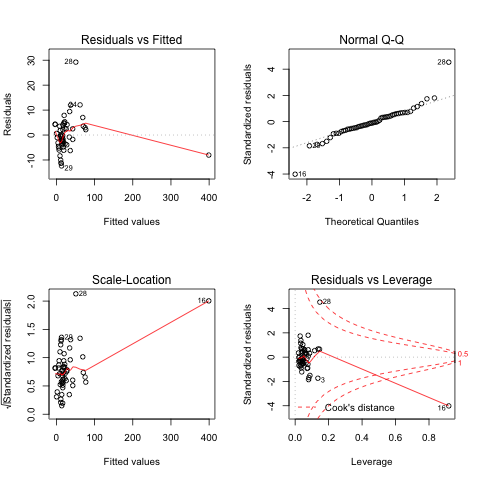

In [55]:
%%R
par(mfrow=c(2,2))
plot(fit)

In [56]:
%%R
df <- read.table('./Data/data-processing/dy_reg.csv', header = T, sep=',')

ggplot(data = df) + 
  geom_point(mapping = aes(x = star_rating, y = sales)) + 
  geom_smooth(mapping = aes(x = star_rating, y = sales), se = F)
ggsave(filename = "./Results/Regression-results/dy_star_rating.png",width = 12,height = 9)

ggplot(data = df) + 
  geom_point(mapping = aes(x = rate_exp_num, y = sales)) + 
  geom_smooth(mapping = aes(x = rate_exp_num, y = sales), se = F)
ggsave(filename = "./Results/Regression-results/dy_rate_exp_num.png",width = 12,height = 9)

ggplot(data = df) + 
  geom_point(mapping = aes(x = rate_exp_txt, y = sales)) + 
  geom_smooth(mapping = aes(x = rate_exp_txt, y = sales), se = F)
ggsave(filename = "./Results/Regression-results/dy_rate_exp_txt.png",width = 12,height = 9)

fit <- lm(sales ~ star_rating + rate_exp_num + rate_exp_txt, data=df)
summary(fit)


Call:
lm(formula = sales ~ star_rating + rate_exp_num + rate_exp_txt, 
    data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-107.729   -4.439   -4.008    0.520  105.474 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   100.266      2.287   43.85   <2e-16 ***
star_rating   -95.226      1.024  -93.04   <2e-16 ***
rate_exp_num   10.348      8.083    1.28    0.201    
rate_exp_txt  189.009      8.303   22.76   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 13.11 on 469 degrees of freedom
Multiple R-squared:  0.9625,	Adjusted R-squared:  0.9622 
F-statistic:  4007 on 3 and 469 DF,  p-value: < 2.2e-16



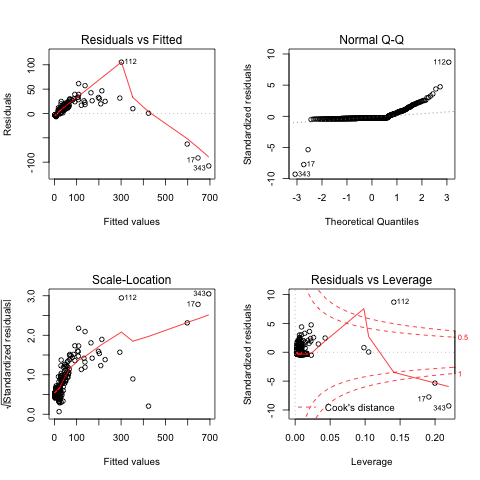

In [57]:
%%R
par(mfrow=c(2,2))
plot(fit)

In [58]:
%%R
df <- read.table('./Data/data-processing/pc_reg.csv', header = T, sep=',')

ggplot(data = df) + 
  geom_point(mapping = aes(x = star_rating, y = sales)) + 
  geom_smooth(mapping = aes(x = star_rating, y = sales), se = F)
ggsave(filename = "./Results/Regression-results/pc_star_rating.png",width = 12,height = 9)

ggplot(data = df) + 
  geom_point(mapping = aes(x = rate_exp_num, y = sales)) + 
  geom_smooth(mapping = aes(x = rate_exp_num, y = sales), se = F)
ggsave(filename = "./Results/Regression-results/pc_rate_exp_num.png",width = 12,height = 9)

ggplot(data = df) + 
  geom_point(mapping = aes(x = rate_exp_txt, y = sales)) + 
  geom_smooth(mapping = aes(x = rate_exp_txt, y = sales), se = F)
ggsave(filename = "./Results/Regression-results/pc_rate_exp_txt.png",width = 12,height = 9)

fit <- lm(sales ~ star_rating + rate_exp_num + rate_exp_txt, data=df)
summary(fit)


Call:
lm(formula = sales ~ star_rating + rate_exp_num + rate_exp_txt, 
    data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-124.809   -0.660   -0.594   -0.298   64.069 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept)   124.6577     0.3403  366.278   <2e-16 ***
star_rating  -123.3753     0.3003 -410.775   <2e-16 ***
rate_exp_num   -0.3373     0.8061   -0.418    0.676    
rate_exp_txt  278.4941     1.0420  267.258   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.426 on 5428 degrees of freedom
Multiple R-squared:  0.9695,	Adjusted R-squared:  0.9695 
F-statistic: 5.756e+04 on 3 and 5428 DF,  p-value: < 2.2e-16



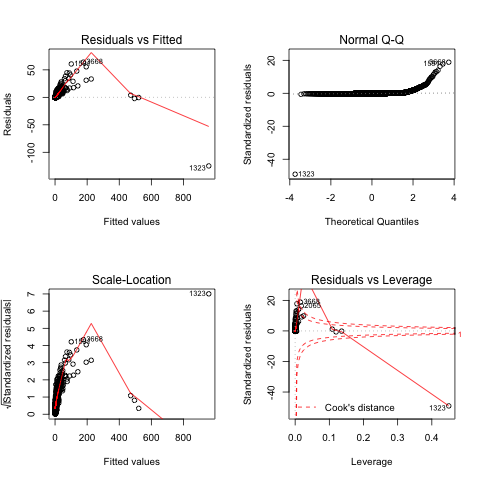

In [59]:
%%R
par(mfrow=c(2,2))
plot(fit)

# Measures that Suggests Reputation Trends

## Time Flow for  Products' Reputations

In [60]:
def TimeFlow(product):
    df = product.copy()

    date = []
    for i in df.index:
        date.append(parser.parse(df.loc[i, 'review_date']))
    df.review_date = date

    year_month = []
    for i in df.index:
        year_month.append((df.loc[i, 'review_date'].year, df.loc[i, 'review_date'].month))

    df.index = year_month
    index = pd.MultiIndex.from_tuples(year_month)
    df = df.reindex(index)
    
    year = list(set(df.index.get_level_values(0)))
    month = list(set(df.index.get_level_values(1)))
    frame_date = pd.DataFrame()
    iindex = [(i, j) for i in year for j in month]
    for i in range(len(year)):
        for j in range(len(month)):
            index_year = year[:i+1]
            index_month = month[:j+1]
            first = df.loc[(year[:i+1],month[:j+1]), :]
            if i > 0:
                secon = df.loc[(year[:i],month[j+1:]), :]
                group = GroupAnalysis(first.append(secon))
                star_mean = pd.DataFrame(np.mean(group)[-2:])
                frame_date = frame_date.append(star_mean)
            else:
                group = GroupAnalysis(first)
                if group.shape[0] > 0:
                    star_mean = pd.DataFrame(np.mean(group)[-2:])
                    frame_date = frame_date.append(star_mean)
                    
    fd = pd.DataFrame(np.array(frame_date).reshape(-1, 2))
    iin = iindex[-fd.shape[0]:]
    fd.index = iin
    fd.columns = ['rate_exp_num', 'rate_exp_txt']
    fd = fd.reindex(pd.MultiIndex.from_tuples(iin, names=('year', 'month')))

    return fd

In [61]:
time_pc = TimeFlow(pc)
time_pc.to_csv(f'{processing_data_path}/pc_time_star.csv')
time_pc

rate_exp_num  rate_exp_txt
year month                            
2003 4          2.000000      5.000000
     5          2.000000      5.000000
     6          2.000000      5.000000
     7          2.000000      5.000000
     8          2.000000      5.000000
...                  ...           ...
2015 8          1.437399      1.406424
     9          1.336469      1.406424
     10         1.377966      1.406424
     11         1.500868      1.406424
     12         1.381263      1.406424

[153 rows x 2 columns]

In [62]:
time_dy = TimeFlow(dy)
time_dy.to_csv(f'{processing_data_path}/dy_time_star.csv')
time_dy

rate_exp_num  rate_exp_txt
year month                            
2002 3          5.000000      5.000000
     4          5.000000      5.000000
     5          5.000000      5.000000
     6          5.000000      5.000000
     7          5.000000      5.000000
...                  ...           ...
2015 8          1.560424      1.544859
     9          1.525350      1.544859
     10         1.552641      1.544859
     11         1.575438      1.544859
     12         1.581237      1.544859

[166 rows x 2 columns]

In [63]:
time_wv = TimeFlow(wv)
time_wv.to_csv(f'{processing_data_path}/wv_time_star.csv')
time_wv

rate_exp_num  rate_exp_txt
year month                            
2004 6          2.500000      2.500000
     7          2.137434      2.450616
     8          2.198276      2.450616
     9          1.760264      3.286293
     10         1.737963      3.286293
...                  ...           ...
2015 8          1.272251      1.345257
     9          1.299822      1.345257
     10         1.308364      1.345257
     11         1.280379      1.345257
     12         1.339884      1.345257

[139 rows x 2 columns]

# Measure Combinations that Indicate Products’ Success/ Failure

## Correlation of time series in corner detection

In [64]:
date_data = pd.read_csv(f'{processing_data_path}/df_inflection.csv', index_col='index')

In [65]:
date_data.columns

Index(['review_date', 'star_rating', 'multi', 'helpful_by_total', 'count',
       'count_month2', 'helpful_votes', 'total_votes', 'vine', 'helpful_ratio',
       'neg', 'neu', 'pos', 'verified_purchase', 'unhelpful_ratio',
       'understandable', 'complexity', 'one_side', 'two_sides', 'att_neg',
       'att_neu', 'att_pos', 'star_rating_helpful', 'plot_count'],
      dtype='object')

In [66]:
reg_models = {
    'linear': LinearRegression(),
}

In [67]:
# date flow: y = "plot_count"
date_data_features = ['plot_count','star_rating','helpful_ratio','neg','pos',
                      'unhelpful_ratio','understandable','complexity', 'one_side','two_sides',
                      'att_neg','att_pos','star_rating_helpful']
Regression(frame=date_data, features=date_data_features, n_splits=2, words='date flow: y = "plot_count"')

date flow: y = "plot_count"
              linear    -14.185511    0.8514
------------------------------------------------------------
intercept = 21.209713432792167
[(14.553686896498393, 'pos'), (11.739850023090737, 'two_sides'), (2.5406251524182872, 'star_rating'), (1.9120583650768104, 'neg'), (0.7567745420111028, 'star_rating_helpful'), (0.0, 'att_neg'), (-1.0332830120215688, 'helpful_ratio'), (-2.3062348030090303, 'unhelpful_ratio'), (-7.098677528387136, 'att_pos'), (-7.09867752838714, 'one_side'), (-16.018811082700953, 'complexity'), (-21.375805628571285, 'understandable')]
------------------------------------------------------------
Feature importance:
[(0.44941507223994526, 'two_sides'), (0.17734047244758794, 'pos'), (0.08684137619698656, 'helpful_ratio'), (0.0711450972346566, 'understandable'), (0.05575583752050009, 'complexity'), (0.04648763003689278, 'neg'), (0.04470322924529586, 'unhelpful_ratio'), (0.03248992226011986, 'star_rating'), (0.016804419907391434, 'att_pos'), (0.01

In [68]:
# date flow: y = "count"
date_data_features = ['count','star_rating','helpful_ratio','neg','pos',
                      'unhelpful_ratio','understandable','complexity', 'one_side','two_sides',
                      'att_neg','att_pos','star_rating_helpful']
Regression(frame=date_data, features=date_data_features, n_splits=2, words='date flow: y = "count"')

date flow: y = "count"
              linear     -4.582011    0.9080
------------------------------------------------------------
intercept = 4.000000000000005
[(11.999999999999998, 'two_sides'), (1.5000000000000016, 'one_side'), (1.5000000000000016, 'att_pos'), (6.6012442471936115e-15, 'star_rating_helpful'), (5.2123519515472584e-15, 'complexity'), (1.758468209060578e-15, 'helpful_ratio'), (0.0, 'att_neg'), (-1.6604406307802727e-15, 'understandable'), (-2.6197565541960573e-15, 'pos'), (-3.2870079260442425e-15, 'unhelpful_ratio'), (-7.56288005417307e-15, 'star_rating'), (-7.939737907340536e-15, 'neg')]
------------------------------------------------------------
Feature importance:
[(0.6430719561308227, 'two_sides'), (0.15484143418380125, 'pos'), (0.045793246042389574, 'complexity'), (0.04078377950772097, 'neg'), (0.0339573920980101, 'understandable'), (0.0211979225348745, 'star_rating'), (0.01403853181820296, 'att_pos'), (0.013316309672416551, 'star_rating_helpful'), (0.012558516655120

# Relationship Between Ratings and Review Types & Descriptors

- Dive deeper into Reviews

## Add Reviews

In [69]:
def AddReviews(data=wv, split=False, total=None):
    total_data = data if not split else total
    group = pd.DataFrame(total_data.product_parent.value_counts())
    group['review'] = np.array([['price,']*group.shape[0]]).reshape(-1, 1)
    group.drop('product_parent', axis=1, inplace=True)
    for i in total_data.index:
        for j in group.index:
            if total_data.loc[i,'product_parent'] == j:
                group.loc[j, 'review'] += total_data.loc[i, 'review_headline']
    return group

In [70]:
wv_reg_review = pd.concat([wv_reg, AddReviews(data=wv)], axis=1)
wv_reg_review.index.name = 'index'
wv_reg_review.to_csv(f'{processing_data_path}/wv_reg_review.csv')

dy_reg_review = pd.concat([dy_reg, AddReviews(data=dy)], axis=1)
dy_reg_review.index.name = 'index'
dy_reg_review.to_csv(f'{processing_data_path}/dy_reg_review.csv')

In [71]:
# time exhausted
#pc_reg = pd.concat([pc_reg, AddReviews(data=pc)], axis=1)
#pc_reg.to_csv(f'{processing_data_path}/pc_reg.csv')

# Also tired to split into several small frame, while, also exhausted
#AddReviews(data=pc_reg.iloc[:5, :], split=True, total=pc)

## Extract keywords from review

Methods we used:
- Word of Bags
- TF-IDF
- SpectralCoclusters

In [72]:
def number_normalizer(tokens):
    """ Map all numeric tokens to a placeholder.

    For many applications, tokens that begin with a number are not directly
    useful, but the fact that such a token exists can be relevant.  By applying
    this form of dimensionality reduction, some methods may perform better.
    """
    return ("#NUMBER" if token[0].isdigit() else token for token in tokens)

In [73]:
class NumberNormalizingVectorizer(TfidfVectorizer):
    def build_tokenizer(self):
        tokenize = super().build_tokenizer()
        return lambda doc: list(number_normalizer(tokenize(doc)))

In [74]:
def bicluster_ncut(i, cocluster, X):
    rows, cols = cocluster.get_indices(i)
    if not (np.any(rows) and np.any(cols)):
        import sys
        return sys.float_info.max
    row_complement = np.nonzero(np.logical_not(cocluster.rows_[i]))[0]
    col_complement = np.nonzero(np.logical_not(cocluster.columns_[i]))[0]

    weight = X[rows][:, cols].sum()
    cut = (X[row_complement][:, cols].sum() + X[rows][:, col_complement].sum())
    return cut / weight

In [75]:
def most_common(d):
    """Items of a defaultdict(int) with the highest values.

    Like Counter.most_common in Python >=2.7.
    """
    return sorted(d.items(), key=operator.itemgetter(1), reverse=True)

In [76]:
def AddTarget(frame):
    arg = []
    for i in range(len(frame.index)):
        arg.append(np.argmax(frame.loc[frame.index[i], ['neg', 'pos', 'neu']]))

    argframe = pd.DataFrame(arg, dtype=int)
    argframe.index = frame.index
    argframe.columns = ['attitude_target']

    return pd.concat([frame, argframe], axis=1)

In [77]:
def ExtractKeywords(data):
    for i in range(data.shape[0] - 1):
        
        newsgroups_data = list(data.review[i:i+2])
        newsgroups_target = np.array(data.attitude_target[i:i+2], dtype=int)
        newsgroups_target_names = ['negtive', 'neutral', 'positive']
        y_true = newsgroups_target

        vectorizer = NumberNormalizingVectorizer(stop_words='english', min_df=1, max_df=10000)
        cocluster = SpectralCoclustering(n_clusters=3, random_state=0)
        kmeans = MiniBatchKMeans(n_clusters=3, batch_size=20000, random_state=0)

        #print("Vectorizing...")
        X = vectorizer.fit_transform(newsgroups_data)

        #print("Coclustering...")
        cocluster.fit(X)
        y_cocluster = cocluster.row_labels_

        feature_names = vectorizer.get_feature_names()
        document_names = list(newsgroups_target_names[i] for i in newsgroups_target)

        bicluster_ncuts = list(bicluster_ncut(i, cocluster, X) for i in range(len(newsgroups_target_names)))
        best_idx = np.argsort(bicluster_ncuts)[:3]

        words = []
        for idx, cluster in enumerate(best_idx):
            n_rows, n_cols = cocluster.get_shape(cluster)
            cluster_docs, cluster_words = cocluster.get_indices(cluster)
            if not len(cluster_docs) or not len(cluster_words):
                continue

            # get words
            out_of_cluster_docs = cocluster.row_labels_ != cluster
            out_of_cluster_docs = np.where(out_of_cluster_docs)[0]
            word_col = X[:, cluster_words]
            word_scores = np.array(word_col[cluster_docs, :].sum(axis=0) -
                                word_col[out_of_cluster_docs, :].sum(axis=0))
            word_scores = word_scores.ravel()
            important_words = list(feature_names[cluster_words[i]]
                                for i in word_scores.argsort()[:-11:-1])
            words.append(important_words)
            
        data.loc[data.index[i],'keywords'] = ','.join(words[0])
        if i == data.shape[0] - 2:
            data.loc[data.index[i+1],'keywords'] = ','.join(important_words)
        
    return data

In [78]:
wv_reg_review = pd.read_csv(f'{processing_data_path}/wv_reg_review.csv', index_col='index')
dy_reg_review = pd.read_csv(f'{processing_data_path}/dy_reg_review.csv', index_col='index')

wv_with_keys = ExtractKeywords(AddTarget(wv_reg_review))
dy_with_keys = ExtractKeywords(AddTarget(dy_reg_review))

wv_with_keys.to_csv(f'{processing_data_path}/wv_with_keys.csv')
dy_with_keys.to_csv(f'{processing_data_path}/dy_with_keys.csv')

In [79]:
#pc_reg_review = pd.read_csv(f'{processing_data_path}/pc_reg.csv', index_col='index')
#pc_with_keys = ExtractKeywords(AddTarget(pc_reg_review))
#pc_with_keys.to_csv(f'{processing_data_path}/pc_with_keys.csv')

## Create word clouds

An online word cloud generator that supports more customizable content: &ensp;
[WordItOut](http://www.yyyweb.com/demo/inner-show/word-itout.html)

In [80]:
def WordCloudPictures(data, category='wv'):
    
    mk = [imread(f'{word_clouds_path}/masks/{k}.jpeg') for k in range(1,17)]
    
    for i in range(len(data.index)):
        wordcloud = WordCloud(mask=mk[i%16], background_color='white').generate(data.keywords[data.index[i]])
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        #plt.show()
        plt.savefig(f'{word_clouds_path}/{category}/{category}_{i+1}.png', dpi = 200)

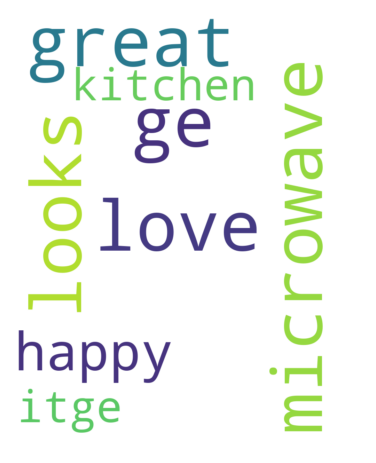

In [81]:
WordCloudPictures(wv_with_keys, category='wv')  # 55 pieces
#WordCloudPictures(dy_with_keys, category='dy') # 500+ pieces

# Additional attempts

## Word of Bag & TF-IDF -> word vector / vocabulary / feature dictionary

In [82]:
# CountVectorizer
count_vect = CountVectorizer(stop_words="english", decode_error='ignore')
X_train_counts = count_vect.fit_transform(df.review_body)
X_train_counts.shape

(32021, 22249)

In [83]:
# TfidfTransformer, TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_tf = vectorizer.fit_transform(pc.review_body)
X_train_tf.shape

(18939, 16412)

In [84]:
vectorizer.vocabulary_.items()
feature_dict = {v: k for k, v in vectorizer.vocabulary_.items()}

X = X_train_tf.toarray()
place = np.transpose(np.nonzero(X))

See more informations about nltk, such as feature_dict, sentiment analysis, etc.

- [nltk package](https://www.nltk.org/api/nltk.sentiment.html)

- [examples of nltk sentiment](https://vimsky.com/zh-tw/examples/detail/python-method-nltk.sentiment.vader.SentimentIntensityAnalyzer.html)

## nltk: stopwords / auto-summary

In [ ]:
sentences = []
for s in df.review_body:
    sentences.append(sent_tokenize(s))

sentences = [y for x in sentences for y in x]

word_embeddings = {}
with open('~/Downloads/glove.6B/glove.6B.100d.txt', encoding='utf-8'):
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs

# remove punctuations, numbers and special characters
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")

# make alphabets lowercase
clean_sentences = [s.lower() for s in clean_sentences]

stop_words = stopwords.words('english')